In [3]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2.ok')

Assignment: proj2
OK, version v1.18.1



# Project 2: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation


## This Assignment
In this project, I created a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. Work is evaluated based on model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

# Part I - Initial Analysis

In [4]:
!pip install wordcloud

In [5]:
!pip install pillow

In [6]:
import numpy as np
import pandas as pd
import re
import wordcloud
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from sklearn.metrics import roc_curve

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [7]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head(10)

Using version already downloaded: Wed Aug  5 06:46:14 2020
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Wed Aug  5 06:46:13 2020
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0
5,5,Subject: Five\n,url: http://diveintomark.org/archives/2002/10/...,0
6,6,Subject: [SAdev] [Bug 1006] Spamassassin's bui...,http://www.hughes-family.org/bugzilla/show_bug...,0
7,7,Subject: One of a kind Money maker! Try it for...,------000000000000000000000\n content-type: te...,1
8,8,Subject: freshrpms.net resources (was Re: use ...,"once upon a time, brian wrote :\n \n > yeah...",0
9,9,Subject: use of base image / delta image for a...,"hi,\n \n i was inspired by a mode of operation...",0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [60]:
original_training_data['subject'] = original_training_data['subject'].replace(np.nan, "", regex=True)
original_training_data['email'] = original_training_data['email'].replace(np.nan, "", regex=True)
original_training_data['subject'].isna().sum()
original_training_data['email'].isna().sum()

0

In [9]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [10]:
spamm = original_training_data.loc[original_training_data['spam'] == 1]
spamm['email'].head(10)


2     <html>\n <head>\n </head>\n <body>\n <font siz...
7     ------000000000000000000000\n content-type: te...
10    <html>\n <head>\n <title>reliaquote - save up ...
14    dear ricardo1 ,\n \n <html>\n <body>\n <center...
17    <body bgcolor=#ffffff>\n <div><font face=arial...
21    interested in renting or selling your\n timesh...
23    <html>\n <body>\n <p>shoot your wad all over h...
29    dear cypherpunks =2c\n \n =3cbody bgcolor=3d#f...
33    <html>\n <body>\n \n <center>\n <font face="ar...
35    (see disclaimer below)\n \n \n dear internet m...
Name: email, dtype: object

In [11]:
hamm = original_training_data.loc[original_training_data['spam'] == 0]
first_ham = hamm['email'].iloc[0]
spamm = original_training_data.loc[original_training_data['spam'] == 1]
first_spam = spamm['email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [12]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

The email classified as spam has more html tags than the email classified as ham. 

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [61]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

(7513, 4)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [14]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for t in words:
        cont = texts.str.contains(t, regex=False)
        for i in cont:
            if i == False:
                indicator_array.append(0)
            else:
                indicator_array.append(1)
    indicator_array = np.reshape(indicator_array, (len(texts), len(words)), order='F')
    return indicator_array

In [15]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [16]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


In [17]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
train.head()


,id,subject,email,spam
0,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0
1,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0
2,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0
3,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0
4,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0


### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

[Text(0.5, 0, 'Words'),
 Text(0, 0.5, 'Proportion of Emails'),
 Text(0.5, 1.0, 'Frequency of Words in Spam/Ham Emails')]

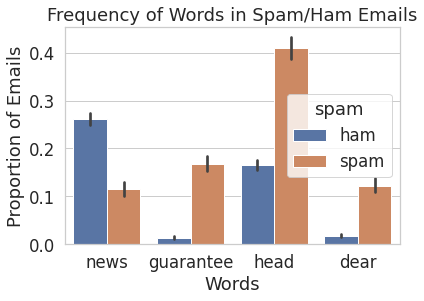

In [18]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
words = ['news', 'guarantee', 'head', 'dear']
counts = words_in_texts(words, train['email'])
new = train.copy(deep=False)
new['news'] = [i[0] for i in counts]
new['guarantee'] = [i[1] for i in counts]
new['head'] = [i[2] for i in counts]
new['dear'] = [i[3] for i in counts]
new['spam'].replace({0:'ham', 1:'spam'}, inplace=True)
new = new[['news', 'guarantee', 'head', 'dear', 'spam']]
new = new.melt('spam')
fig = sns.barplot(x = new['variable'], y = new['value'], hue = new['spam'])
fig.set(xlabel = 'Words', ylabel = 'Proportion of Emails', title = 'Frequency of Words in Spam/Ham Emails')

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")


### Question 3b

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Distribution')

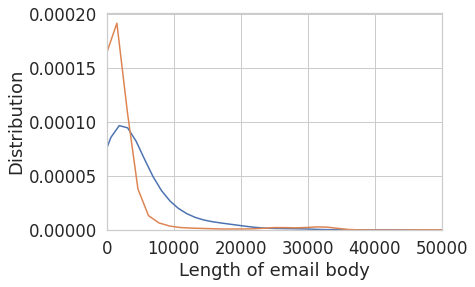

In [19]:
temp = train.copy(deep=False)
temp['length'] = temp['email'].str.len()
sp = temp[temp['spam'] == 1]
hm = temp[temp['spam'] == 0]

sns.distplot(sp['length'], hist = False, label = 'Spam', axlabel = 'Length of email body')
sns.distplot(hm['length'], hist=False, label = 'Ham', axlabel = 'Length of email body')
plt.xlim(0, 50000)
plt.ylabel("Distribution")


# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [20]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']
dataa = words_in_texts(some_words, train['email'])

X_train = pd.DataFrame(data = dataa, columns=['drug', 'bank', 'prescription', 'memo', 'private'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(   drug  bank  prescription  memo  private
 0     0     0             0     0        0
 1     0     0             0     0        0
 2     0     0             0     0        0
 3     0     0             0     0        0
 4     0     0             0     1        0,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [21]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=False)
model.fit(X_train, Y_train)


training_accuracy = model.score(X_train, Y_train)


print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7584187408491947


In [23]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [24]:
Y_train.value_counts()


0    5595
1    1918
Name: spam, dtype: int64

In [25]:
zero_predictor_fp = 0
zero_predictor_fn = 1918

In [26]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [27]:
zero_predictor_acc = (5595/(5595 + 1918))
zero_predictor_recall = 0

In [28]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

For the zero predictor the number of false positives will be 0 because all values are classified as 0 therefore there will be no 1s which could be falsely classified. The number of false negatives is 1918 which is the number of 1s in the training set because all of the 1 values were classified as zero therefore they are false negatives. The accuracy is the 5595 which is the number of actual values that are 0 divided by the total number of values. The recall is 0 because the number of true positives is 0 since all values are classified as 0. 

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [29]:
X_pred =  model.predict(X_train)
tp = sum((Y_train == X_pred) & (Y_train == 1))
tn = sum((Y_train == X_pred) & (Y_train == 0))
fp = sum((Y_train != X_pred) & (Y_train == 0))
fn = sum((Y_train != X_pred) & (Y_train == 1))
logistic_predictor_precision = tp/(tp + fp)
logistic_predictor_recall = tp/(tp + fn)
logistic_predictor_far = fp/(fp + tn)
logistic_predictor_precision, logistic_predictor_recall, logistic_predictor_far

(0.5948434622467772, 0.1684045881126173, 0.03932082216264522)

In [30]:
ok.grade("q6d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

In [31]:
fp, fn, tn, tp, fp+fn


(220, 1595, 5375, 323, 1815)

There are more false negatives than false positives when using this logistic regression classifier.

### Question 6f

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

In [32]:
sum(Y_train == X_pred)/len(X_pred)

0.7584187408491947

In [33]:
Y_train.value_counts()

5595/(5595 + 1918)

0.7447091707706642

In [34]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

1. The prediction accuracy for the zero predictor classifier was 74.5% which is only slightly lower than the logistic regression accuracy of 75.6%. 
2. The words given in some_words are what the entire classification is based on. These words are not found often in the email contents therefore are not a good base for the classification. The most used word is only used in 4% of the emails which proves it is inaccurate to classify based on these words.

3. Although both classifiers have similar accuracy percentages, the preferred classifier for a spam filter would be the logistic regression classifier because the number of incorrect prediction (fp + fn) is 1815 which is less than the incorrect predictions of the zero predictor 1918. Also the zero predictor has a relatively high accuracy because most emails are not spam therefore there are many 0 values and correct predictions but if all values are classified as 0 then there is no classification being done, rather they are all categorized as ham and no spam is predicted. 

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

**Kaggle limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on the entire set when submitting to Kaggle (the accuracy that will determine your score for question 10).

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

<AxesSubplot:xlabel='variable', ylabel='value'>

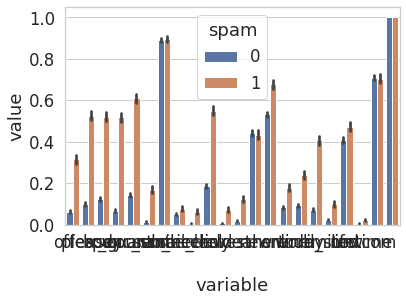

In [35]:
#$, html, offer, body, head, <
#vals = words_in_texts(['html', 'offer', 'please', '$','body', 'head', 'guarantee', 'sincerely', '100%', 'click', 'money'], val['email'])
#check numbers
#click, risk, 100%, money
temp = train.copy(deep=False)
vals = words_in_texts(['offer', 'please','body','guarantee', 'sincerely', 'click', 
                       'lowest', 'dear', 'new', 'here', 'online', 'today', 'limited',
                       'now', 'lifetime', 'debt', '.com', '\n'], train['email'])
temp['offer'] = [i[0] for i in vals]
temp['please'] = [i[1] for i in vals]
temp['body'] = [i[2] for i in vals]
temp['guarantee'] = [i[3] for i in vals]
temp['sincerely'] = [i[4] for i in vals]
temp['click'] = [i[5] for i in vals]
temp['lowest'] = [i[6] for i in vals]
temp['dear'] = [i[7] for i in vals]
temp['new'] = [i[8] for i in vals]
temp['here'] = [i[9] for i in vals]
temp['online'] = [i[10] for i in vals]
temp['today'] = [i[11] for i in vals]
temp['limited'] = [i[12] for i in vals]
temp['now'] = [i[13] for i in vals]
temp['lifetime'] = [i[14] for i in vals]
temp['debt'] = [i[15] for i in vals]
temp['.com'] = [i[16] for i in vals]
temp['\n'] = [i[17] for i in vals]

#'<' count
ttrain = train.copy(deep=False)
res2 = train['email'].str.count('<')
ttrain['<'] = res2
array = []
for i in ttrain['<']:
    if i > 7:
        array.append(1)
    else:
        array.append(0)
temp['<_count'] = array

#count of punctuation
trainn = train.copy(deep=False)
res1 = train['email'].str.count('\$')
res3 = train['email'].str.count('!')
trainn['!'] = res3
trainn['$'] = res1
trainn['punc_sum'] = trainn.loc[:, ['!', '$']].sum(axis=1)
trainn.sort_values(by = ['punc_sum'], ascending=False)
ar = []
for i in trainn['punc_sum']:
    if i > 2:
        ar.append(1)
    else:
        ar.append(0)
temp['punc_sum'] = ar

#count html
part1 = train['email'].str.count('html')
part2 = train['email'].str.count('body')
part3 = train['email'].str.count('head')
trainn['html'] = part1
trainn['body'] = part2
trainn['head'] = part3
trainn['word_sum'] = trainn.loc[:, ['html', 'body', 'head']].sum(axis=1)
hold = []
for i in trainn['word_sum']:
    if i > 5:
        hold.append(1)
    else: 
        hold.append(0)
temp['word_sum'] = hold

#length of subject
new_train = train.copy(deep=False)
new_train['length'] = train['subject'].str.len()
new_arr = []
for i in new_train['length']:
    if i > 27:
        new_arr.append(1)
    else:
        new_arr.append(0)
temp['sub_len'] = new_arr

#length of email
train2 = train.copy(deep=False)
train2['length'] = train['email'].str.len()
add = []
for i in train2['length']:
    if i > 13550:
        add.append(1)
    else:
        add.append(0)
temp['email_len'] = add


temp = temp[['offer', 'please','body','<_count', 'punc_sum', 'guarantee', 'sub_len', 
             'email_len','sincerely', 'click', 'lowest', 'spam', 'dear', 'new', 'here', 'online', 'today',
             'word_sum', 'limited', 'now', 'lifetime', '.com', '\n']]
temp_graph =  temp.melt('spam')

sns.barplot(x = temp_graph['variable'], y = temp_graph['value'], hue = temp_graph['spam'])

In [36]:
#['html', 'offer', 'please','$','body', 'head', '<_count', 'punc_sum', 'email_len', 'sincerely']
x_train = pd.DataFrame(data = temp, columns=['offer','please', '<_count', 'punc_sum', 'guarantee', 'body', 'sub_len',
                                             'email_len', 'sincerely', 'lowest', 'click', 'dear', 'new', 'online', 
                                              'word_sum', 'now', 'limited', 'lifetime', '.com', '\n'])

y_train = train['spam']


my_model = LogisticRegression(fit_intercept=False)
my_model.fit(x_train, y_train)


training_accuracy = my_model.score(x_train, y_train)

print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9003061360308798


In [37]:
#testing validation accuracy
val_test = val.copy(deep=False)
vals = words_in_texts(['offer', 'please','body','guarantee', 'sincerely', 'click', 'lowest', 
                       'dear', 'new', 'here', 'online', 'today', 'now', 'limited', 'lifetime', 'debt', 
                      '.com', '\n'], val['email'])
val_test['offer'] = [i[0] for i in vals]
val_test['please'] = [i[1] for i in vals]
val_test['body'] = [i[2] for i in vals]
val_test['guarantee'] = [i[3] for i in vals]
val_test['sincerely'] = [i[4] for i in vals]
val_test['click'] = [i[5] for i in vals]
val_test['lowest'] = [i[6] for i in vals]
val_test['dear'] = [i[7] for i in vals]
val_test['new'] = [i[8] for i in vals]
val_test['here'] = [i[9] for i in vals]
val_test['online'] = [i[10] for i in vals]
val_test['today'] = [i[11] for i in vals]
val_test['now'] = [i[12] for i in vals]
val_test['limited'] = [i[13] for i in vals]
val_test['lifetime'] = [i[14] for i in vals]
val_test['debt'] = [i[15] for i in vals]
val_test['.com'] = [i[16] for i in vals]
val_test['\n'] = [i[17] for i in vals]
 
#'<' count
ttrain = val.copy(deep=False)
res2 = val['email'].str.count('<')
ttrain['<'] = res2
array = []
for i in ttrain['<']:
    if i > 7:
        array.append(1)
    else:
        array.append(0)
val_test['<_count'] = array

#count of punctuation
trainn = val.copy(deep=False)
res1 = val['email'].str.count('\$')
res3 = val['email'].str.count('!')
trainn['!'] = res3
trainn['$'] = res1
trainn['punc_sum'] = trainn.loc[:, ['!', '$']].sum(axis=1)
trainn.sort_values(by = ['punc_sum'], ascending=False)
ar = []
for i in trainn['punc_sum']:
    if i > 2:
        ar.append(1)
    else:
        ar.append(0)
val_test['punc_sum'] = ar

#count html
part1 = val['email'].str.count('html')
part2 = val['email'].str.count('body')
part3 = val['email'].str.count('head')
trainn['html'] = part1
trainn['body'] = part2
trainn['head'] = part3
trainn['word_sum'] = trainn.loc[:, ['html', 'body', 'head']].sum(axis=1)
hold = []
for i in trainn['word_sum']:
    if i > 5:
        hold.append(1)
    else: 
        hold.append(0)
val_test['word_sum'] = hold

#length of subject
new_train = val.copy(deep=False)
new_train['length'] = val['subject'].str.len()
new_arr = []
for i in new_train['length']:
    if i > 27:
        new_arr.append(1)
    else:
        new_arr.append(0)
val_test['sub_len'] = new_arr

#length of email
train2 = val.copy(deep=False)
train2['length'] = val['email'].str.len()
add = []
for i in train2['length']:
    if i > 13550:
        add.append(1)
    else:
        add.append(0)
val_test['email_len'] = add


val_test = val_test[['offer','please', '<_count', 'punc_sum', 'guarantee', 'body', 'sub_len',
                                             'email_len', 'sincerely', 'lowest', 'click', 'dear', 'new', 'online', 
                                            'word_sum', 'now', 'limited', 'lifetime', '.com', '\n']]

val_y = val['spam']
val_predictions = my_model.predict(val_test)
val_accuracy = my_model.score(val_test, val_y)
val_accuracy


0.8850299401197604

In [38]:
repfw = train['email'].str.contains('(Re:)|(RE:)|(re:)|(Fw:)|(FW:)|(fw:)', regex=True)
train['repfw'] = repfw.replace({True:0, False: 1})

/tmp/ipykernel_55/2380371833.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  repfw = train['email'].str.contains('(Re:)|(RE:)|(re:)|(Fw:)|(FW:)|(fw:)', regex=True)


In [39]:
#Length of subject
new_train = train.copy(deep=False)
new_train['length'] = train['subject'].str.len()
new_train.sort_values(by = ['length'], ascending=False)
filt = new_train.loc[new_train['length'] > 60]


filt['spam'].value_counts()

0    1149
1     548
Name: spam, dtype: int64

In [40]:
#Length of email
train2 = train.copy(deep=False)
train2['length'] = train['email'].str.len()
train2.sort_values(by = ['length'], ascending=False)
np.mean(train2['length'])
bb = train2.loc[train2['length'] > 2500]
bb['spam'].value_counts()

1    1012
0     985
Name: spam, dtype: int64

In [41]:
#Punctuation count
trainn = train.copy(deep=False)
res1 = train['email'].str.count('\$')
res3 = train['email'].str.count('!')
#res4 = train['email'].str.count('\?')
#trainn['?'] = res4
trainn['!'] = res3
trainn['$'] = res1
trainn['punc_sum'] = trainn.loc[:, ['$', '!']].sum(axis=1)
trainn.sort_values(by = ['punc_sum'], ascending=False)
only = trainn.loc[trainn['punc_sum'] > 1]

only['spam'].value_counts()
#filt = trainn[trainn['$'] > 3]

#filt['spam'].value_counts()


1    1367
0    1246
Name: spam, dtype: int64

In [42]:
#Number of capital letter (subject)
res = train['subject'].str.count(r'[A-Z]')
trainn = train.copy(deep=False)
trainn['sub_cap'] = res
trainn = trainn.sort_values(by = ['sub_cap'], ascending=False)
last = trainn.loc[trainn['sub_cap'] > 7]



last['spam'].value_counts()
#cap_count = []
#for i in trainn['sub_cap']:
    #if i > 17:
        #cap_count.append(1)
    #else:
        #cap_count.append(0)

0    1032
1     670
Name: spam, dtype: int64

In [43]:
#Number of ?
train3 = train.copy(deep=False)
train3['ques'] = train['email'].str.count('\?')
train3.sort_values(by = ['ques'], ascending=False)

                                          

,id,subject,email,spam,repfw,ques
4545,2468,Subject: Tribute MovieMail - Vol. 1 #48\n,this is a multi-part message in mime format.\n...,0,1,135
1852,7492,Subject: Tribute MovieMail - Vol. 1 #48\n,this is a multi-part message in mime format.\n...,0,1,135
5711,6077,Subject: Wrox Press Developer's Journal\n,this is a multi-part message in mime format.\n...,0,0,105
2889,2981,Subject: MEDIA: spamNEWS Digest September 30 -...,spamnews: providing the news about junk e-mail...,0,1,103
1354,259,Subject: MEDIA: spamNEWS Digest September 30 -...,spamnews: providing the news about junk e-mail...,0,1,103
...,...,...,...,...,...,...
3553,2207,Subject: Get the money you need while mortgage...,iieo\n <html>\n <head>\n <title>mortgage compa...,1,1,0
3554,3718,Subject: Save now \n,"*****write down*****\n \n \n hello ,\n \n \n i...",1,1,0
3556,719,Subject: Artist Gallery: Troy Paradise\n,"url: http://www.newsisfree.com/click/-0,861367...",0,1,0
3557,7602,Subject: [ILUG] Marketing SIG has a good start...,|::::::::::::::::::::::::::::::::::::...,0,1,0


In [44]:
#Punctuation count
exc_count = train['email'].str.count(r'!')
traain = train.copy(deep= False)
traain['exc_count'] = exc_count
traain = traain[['exc_count', 'spam']]
traain.sort_values(by = ['exc_count'], ascending=False)



,exc_count,spam
6121,345,0
2641,243,0
2814,243,0
3790,119,0
6299,118,0
...,...,...
1767,0,0
4715,0,0
1765,0,0
4717,0,0


In [45]:
#Number of '<'
ttrain = train.copy(deep=False)
res2 = train['email'].str.count('<')
ttrain['<'] = res2
array = []
for i in ttrain['<']:
    if i > 3:
        array.append(1)
    else:
        array.append(0)
ttrain['<_count'] = array
ttrain['<_count'].value_counts()




0    6029
1    1484
Name: <_count, dtype: int64

<AxesSubplot:xlabel='variable', ylabel='value'>

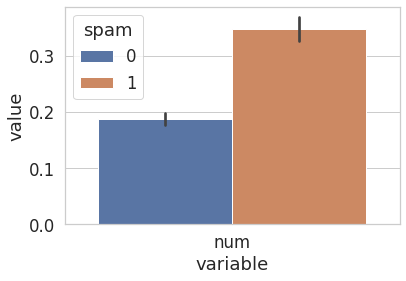

In [46]:
#Numbers in subject
temp2 = train.copy(deep=False)
temp2['num'] = temp2['subject'].str.contains('[0-9]', regex=True)
temp2['num'].replace({True:1, False:0}, inplace=True)
temp2 = temp2[['num', 'spam']]
temp2 = temp2.melt('spam')
sns.barplot(x = temp2['variable'], y = temp2['value'], hue = temp2['spam'])


#new4['repw'] = new4['subject'].str.contains('(Re:)|(RE:)|(re:)|(FW:)|(fw:)|(Fw:)', regex=True)
#results = new4['repw']

In [47]:
#spam emails
spm = train.loc[train['spam'] == 1]
spm['subject'].head()


5                                       Subject: asap\n
13                         Subject: Re: Your VIP Pass\n
15    Subject: wives and girlfriends cheating and wh...
18    Subject: Fw: Offring Membership To 16 Sites Fo...
19        Subject: The Government grants you $25,000!\n
Name: subject, dtype: object

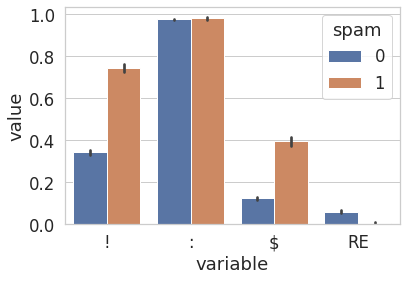

In [48]:
new3 =  train.copy(deep=False)
regex = r'RE:'
values = words_in_texts(['!', ':', '$'], new3['email'])
vals = words_in_texts([regex], new3['subject'])

new3['!'] = [i[0] for i in values]
new3[':'] = [i[1] for i in values]
new3['$'] = [i[2] for i in values]
new3['RE'] = [i[0] for i in vals]
new3 = new3[['!', ':', '$', 'RE','spam']]
new3 = new3.melt('spam')
fig = sns.barplot(x = new3['variable'], y = new3['value'], hue = new3['spam'])

### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->
<!-- EXPORT TO PDF -->

1. To find features that best fit my model I used a lot of trial and error. I constantly referred to the bar chart that compares the proportions of spam/ham emails that contain a certain feature. I added the features that seemed the most promising to catch spam emails to my model and then tested the accuracy on my training data and if it improved I tested it on my validation set. 
2. I tried a couple of features that did not work for example finding key words which I thought would help differentiate spam/ham which did not prove helpful. I also attempted to use the number of integers in an email to see if there was a difference between spam and ham emails in the count of integers they contained. Some features that improved my model were the count of punctuation marks since spam emails seem to have more !, or $, as well as the length of the email subject and content. 
3. It was surprising that some features which seemed to have less significant proportions in the bar chart proved more helpful than other features which seemed to have higher disparity between ham/spam though this might be because it applied better to other datasets that since the model is not supposed to be overfit to the training set. 

### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. Include

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

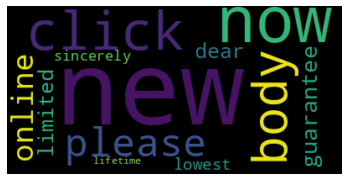

In [49]:
# Write your description (2-3 sentences) as a comment here:
#As a visualization for my model I chose to make a word cloud with the words I chose to use to use to classify spam emails. The dictionary used for the word cloud shows the frequency of the word and the visualization uses this frequency to print the text of the word at a size scaled to the frequency it is found in the emails. These words are meaningful to my model selection because they are exclusively frequent in spam emails therefore are useful in classifying 1s.

# Write the code to generate your visualization here:
words = temp[['offer', 'please','body','guarantee', 'sincerely', 'click', 'lowest', 'dear', 'new', 'online',
'now', 'limited', 'lifetime']].sum(axis=0, skipna=True)
dictionary = words.to_dict
wordcloud = WordCloud()
dictionary
wordcloud.generate_from_frequencies({'please': 1566, 
'body'    :     1689,
'guarantee'  :   402,
'sincerely'  :   138,
'click'    :    2092,
'lowest'    :    176,
'dear'    :      334,
'new'     :     3303,
'online'   :     810,
'now'    :      3189,
'limited'   :    322,
'lifetime'   :    63})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Question 9: ROC Curve

In most cases we won't be able to get no false positives and no false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Kaggle). Refer to the Lecture 22 notebook or Section 17.7 of the course text to see how to plot an ROC curve.



<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

Text(0.5, 1.0, 'my_model ROC Curve')

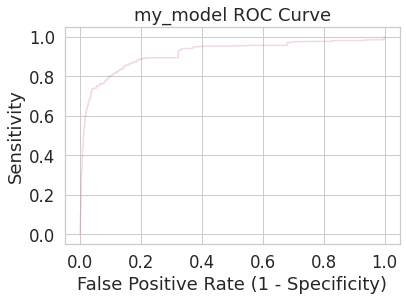

In [52]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

my_model_probabilities = my_model.predict_proba(x_train)[:, 1]
my_model_probabilities
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_train, my_model_probabilities, pos_label=1)
false_positive_rate_values, sensitivity_values, thresholds

plt.step(false_positive_rate_values, sensitivity_values, color='r', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('my_model ROC Curve')

## Confusion Matrix


In [65]:
from sklearn.metrics import confusion_matrix
model_predictions = my_model.predict(x_train)
cnf_matrix = confusion_matrix(train['spam'], model_predictions, labels=[1,0])
print(cnf_matrix)

[[1372  546]
 [ 203 5392]]


Confusion matrix, without normalization
[[1372  546]
 [ 203 5392]]


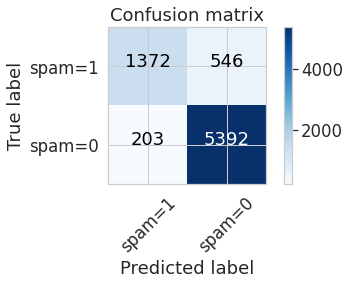

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#print(confusion_matrix(y_test, yhat, labels=[1,0]))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['spam=1', 'spam=0'], normalize= False,  title='Confusion matrix')


# Question 10: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your score for this question will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/c/ds100fa19

*The provided tests check that your predictions are in the correct format, but you must submit to Kaggle to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 15
-->

In [79]:
testing = test.copy(deep=False)
vals = words_in_texts(['offer', 'please','body','guarantee', 'sincerely', 'click', 'lowest', 'dear',
                       'new', 'online', 'now', 'limited', 'lifetime', 'debt', '.com', '\n'], test['email'])
testing['offer'] = [i[0] for i in vals]
testing['please'] = [i[1] for i in vals]
testing['body'] = [i[2] for i in vals]
testing['guarantee'] = [i[3] for i in vals]
testing['sincerely'] = [i[4] for i in vals]
testing['click'] = [i[5] for i in vals]
testing['lowest'] = [i[6] for i in vals]
testing['dear'] = [i[7] for i in vals]
testing['new'] = [i[8] for i in vals]
testing['online'] =[i[9] for i in vals]
testing['now'] = [i[10] for i in vals]
testing['limited'] = [i[11] for i in vals]
testing['lifetime'] = [i[12] for i in vals]
testing['debt'] = [i[13] for i in vals]
testing['.com'] = [i[14] for i in vals]
testing['\n'] = [i[15] for i in vals]

#'<' count
ttrain = test.copy(deep=False)
res2 = test['email'].str.count('<')
ttrain['<'] = res2
array = []
for i in ttrain['<']:
    if i > 7:
        array.append(1)
    else:
        array.append(0)
testing['<_count'] = array

#count of punctuation
trainn = test.copy(deep=False)
res1 = test['email'].str.count('\$')
res3 = test['email'].str.count('!')
trainn['!'] = res3
trainn['$'] = res1
trainn['punc_sum'] = trainn.loc[:, ['!', '$']].sum(axis=1)
trainn.sort_values(by = ['punc_sum'], ascending=False)
only = trainn.loc[trainn['punc_sum'] > 1]
ar = []
for i in trainn['punc_sum']:
    if i > 2:
        ar.append(1)
    else:
        ar.append(0)
testing['punc_sum'] = ar

#length of subject
new_train = test.copy(deep=False)
new_train['length'] = test['subject'].str.len()
new_arr = []
for i in new_train['length']:
    if i > 27:
        new_arr.append(1)
    else:
        new_arr.append(0)
testing['sub_len'] = new_arr

#length of email
train2 = test.copy(deep=False)
train2['length'] = test['email'].str.len()
add = []
for i in train2['length']:
    if i > 13550:
        add.append(1)
    else:
        add.append(0)
testing['email_len'] = add

part1 = test['email'].str.count('html')
part2 = test['email'].str.count('body')
part3 = test['email'].str.count('head')
train2['html'] = part1
train2['body'] = part2
train2['head'] = part3
train2['word_sum'] = train2.loc[:, ['html', 'body', 'head']].sum(axis=1)
hold = []
for i in train2['word_sum']:
    if i > 5:
        hold.append(1)
    else: 
        hold.append(0)
testing['word_sum'] = hold

 
testing = testing[['offer', 'please','body','<_count', 'punc_sum', 'guarantee', 'sub_len', 
             'email_len','sincerely', 'click', 'lowest', 'dear', 'new', 'online', 'now', 'word_sum', 'limited',
                  'lifetime', '.com', '\n']]

testing.fillna(0, inplace=True)

testing
test_predictions = my_model.predict(testing)



In [80]:
ok.grade("q10");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



The following saves a file to submit to Kaggle.

In [72]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')


Created a CSV file: submission_2019-11-24T23:41:47.csv.
You may now upload this CSV file to Kaggle for scoring.


# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 9 EXPORTED QUESTIONS -->

In [ ]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj2.ipynb', 'proj2.pdf')
ok.submit()

Generating PDF...
Saved proj2.pdf


<IPython.core.display.Javascript object>